# Best window's size

## 0. Data

In [1]:
from recommender_system import RedSQL, load_cfg
from mab import get_bandits_events
import time

In [2]:
t1=time.time()

cfg = load_cfg()

In [3]:
with RedSQL(cfg['redshift']) as rs:
    data = get_bandits_events(rs)

t2=time.time()
print(t2-t1)

175.717351436615


## 1. Window size

When evaluating recommender systems, the quality of data should be taken into account. In our case we use only (the most) recent part of the dataset.
We do this through a sliding window of size $n$, which influences both the optimal performance of individual algorithms and comparisons between algorithms (Verachtert et al., 2022).

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator, DayLocator, WeekdayLocator
import numpy as np
import datetime

from collections import Counter

from mab import compute_bandit_metrics, compute_pulls
from mab.tag import TypeTag

In [5]:
def display_activity(pulls, time_pattern='%Y-%m-%d'):
    fig, ax = plt.subplots(1, 1)
    for tag, stats in pulls.items():             #tag=key, stats=value
        activity = sorted([(k, v) for k, v in Counter(t.strftime(time_pattern)
                                    for t in stats['time']).items()])
        days = [datetime.datetime.strptime(t[0], time_pattern) for t in activity]
        recs = [t[1] for t in activity]
        ax.plot(days, recs, label=tag)
    plt.ylim([0, None])
    plt.xlim([days[0], days[-1]])
    plt.legend()
    plt.ylabel('Recommendations')
    plt.xlabel('Time')
    fig.autofmt_xdate()
    ax.xaxis.set_major_locator(WeekdayLocator())
    ax.xaxis.set_minor_locator(DayLocator())
    ax.grid(True)
    plt.show()

### 1.1 Quantity

In [6]:
# Global analysis, i.e. keeping eventPeople, Planning, Product, ... altogether (which corresponds to "Per algorithm" since there's no bandit monitoring yet)

pulls = compute_pulls(data, store_time=True)
pulls

{'version-v2.3.0': {'success': [False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   True,
   False,
   False,
   True,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   Fa

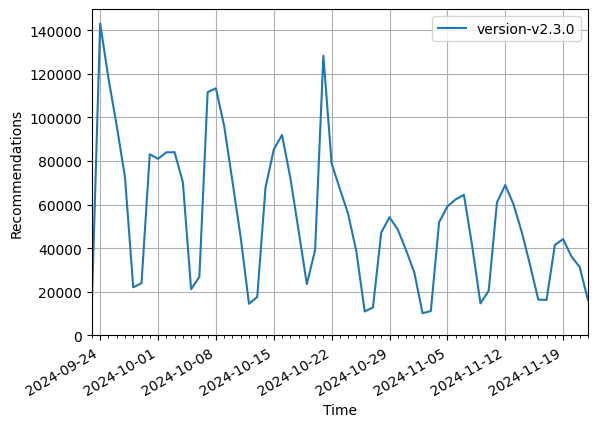

In [7]:
display_activity(pulls)

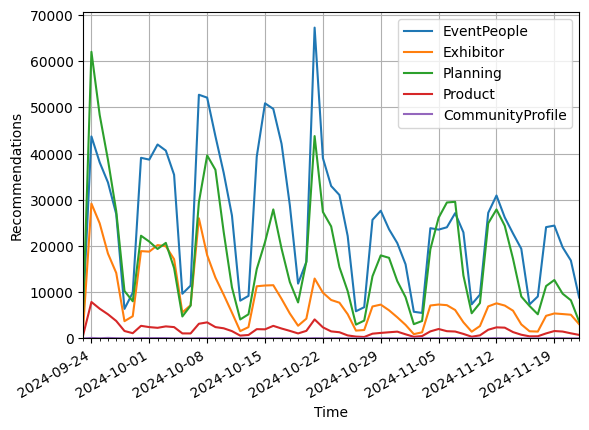

In [8]:
# Per item analysis, i.e. dividing EventPeople, Planning, Product, ...

pulls_type = compute_pulls(data, tag_extractor=TypeTag(), store_time=True)

display_activity(pulls_type)

### 1.2 Quality

We observe the trend of click rates.

In [9]:
def display_rates(rates, data_name='moving_avg', y_label='Click rate', pruning=400):
    fig, ax = plt.subplots(1, 1)
    for tag, stats in rates.items():
        rate = stats[data_name][::pruning]
        if 'time' in stats:
            ax.plot(stats['time'][::pruning], rate, label=tag)
        else:
            ax.plot(np.linspace(0, 1, len(rate)), rate, label=tag)
    plt.ylim([0, None])
    if 'time' in stats:
        plt.xlim([stats['time'][0], stats['time'][-1]])
        fig.autofmt_xdate()
        ax.xaxis.set_major_locator(WeekdayLocator())
        ax.xaxis.set_minor_locator(DayLocator())
    else:
        plt.xlim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel('Time')
    if len(rates) > 1:
        plt.legend()
    ax.grid(True)
    plt.show()


# I define "geometric_average" which is not the usual geoemtric average (x_1 * ... * x_n)^{1/n},
# but instead the ARITHMETIC average but with parameters rho and 1-rho that corresponds to having weights decreasing with geometric distribution.
# Moving average of binary success data to each tag's statistics in the input dictionary.
# Recent successes have a higher influence, and older successes gradually diminish in impact according to the specified decay rate rho.

def geometric_average(pulls, size=1000):
    rho = 1/size
    for tag, stats in pulls.items():
        successes = stats['success']
        moving_avg = np.zeros(len(successes))                             # n-day moving average = average value in the last n-days period
        for i, s in enumerate(successes):
            moving_avg[i] = (1-rho) * moving_avg[i-1] + rho * int(s)
        pulls[tag]['moving_avg'] = moving_avg


# In order to take into account only what happens now, not old events that would not give a true estimation of what is happening in present time
# Doesn't return anything but modifies pulls (inplace)

        
# Here time window is expressed in number of actions (because simpler) =?
# If you have ideas to auto-tune the average computation, you are welcome =?

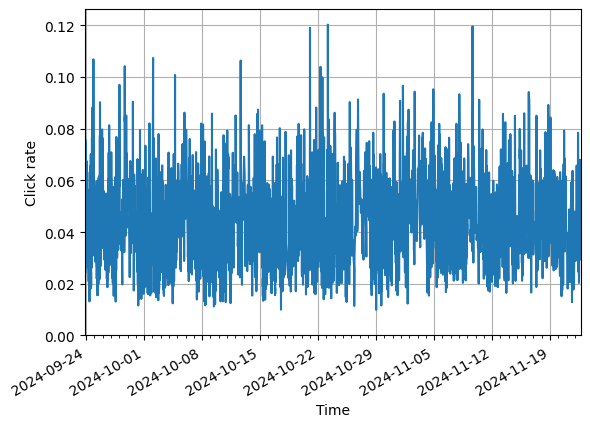

In [10]:
# TIME: Global analysis

pulls = compute_pulls(data, store_time=True)

geometric_average(pulls, size=5*10**2)
display_rates(pulls)

# Click rate between 1% and 12%. Precise plot but too noisy

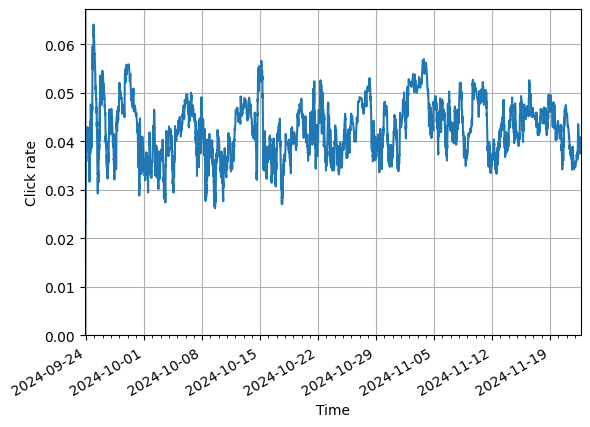

In [11]:
geometric_average(pulls, size=10**4)
display_rates(pulls)
# Clearer

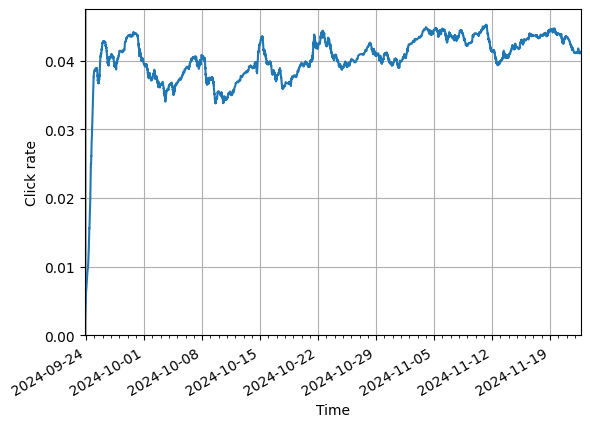

In [12]:
# Increasing "size" from 10**4 to 10**5, i.e. decreasing frequency, stretches the graph horizontally

geometric_average(pulls, size=10**5)
display_rates(pulls)

# I notice that the click rate (i.e. the quality of recommendation) is generally between 3 and 5% (quite low, could definitely be improved)
# By increazing the size, the click-through rate gets smoothed (before 0.065, now 0.045), but we notice that in recent time the click-through rate is preserved

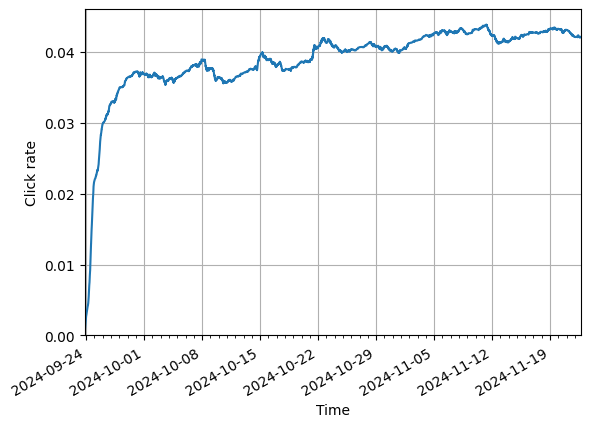

In [13]:
geometric_average(pulls, size=2.5*10**5)
display_rates(pulls)
# Definitely too much: for n larger than 10**5 we do not have anymore a clead idea of what is going on, and only recent click-rates are reliable 

Hence, size $10^5$ is a sweet spot in the trade-off between stability of the average and reactivity to changes.

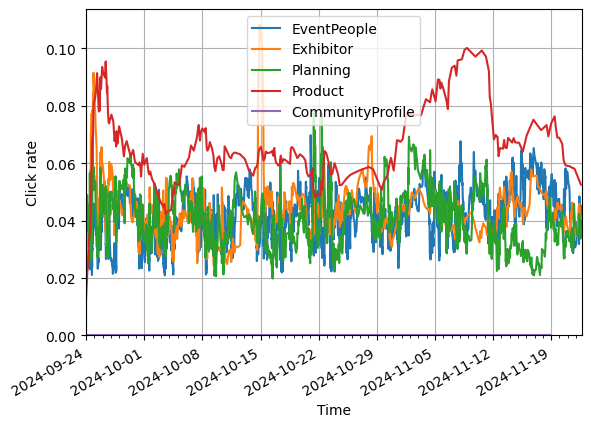

In [14]:
# TIME: Per item analysis

geometric_average(pulls_type, size=3000)
display_rates(pulls_type)

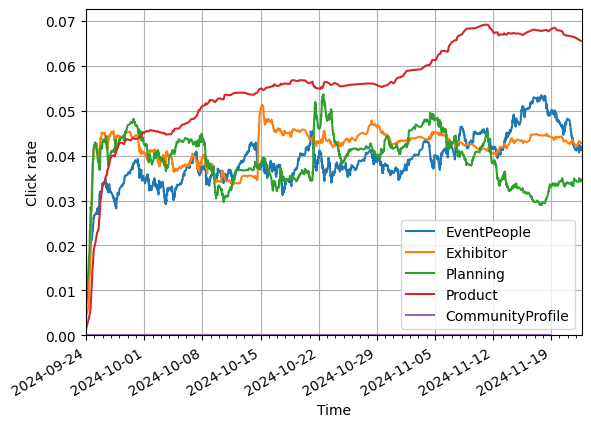

In [15]:
geometric_average(pulls_type, size=3*10**4)         #3*10**4 is enough
display_rates(pulls_type)

# The tendency is modified, as the click-through rate gets smoothed. In moving average, you discard the frequencies higher than your moving window to gain in visibility.
# The activity of products (red) is really low, so the characteristic time window for them is much larger than for the rest. This justify the different tendency of that line.

### 2. Weeks

Following our consideration on weekly patterns, we want to better investigate it, in order to find the best window size.

In [16]:
# Example week 

from datetime import datetime, timezone, timedelta

# Date range of the week
start_date = datetime(2024, 9, 23, tzinfo=timezone.utc)
end_date = datetime(2024, 9, 30, tzinfo=timezone.utc)

# Extract pulls
success_list = pulls['version-v2.3.0']['success']
time_list = pulls['version-v2.3.0']['time']

# Count pulls which succeeded in the selected week 
count_succ = sum(
    success and start_date <= time <= end_date
    for success, time in zip(success_list, time_list)
)

# Count total pulls in the selected week 
count_pull = sum(start_date <= time <= end_date
    for success, time in zip(success_list, time_list))

# CTR in the selected week 
ctr=count_succ/count_pull

print(f"{start_date.date()} to {end_date.date()} (excluded): {count_succ} successes, {count_pull} pulls, {ctr} click-through rate")

# 23-29/09/2024: 21063 successes, 490953 total pulls, 4.29% click-through rate

2024-09-23 to 2024-09-30 (excluded): 21063 successes, 490953 pulls, 0.04290227374107094 click-through rate


In [17]:
# Pulls for each week 

from datetime import datetime, timezone, timedelta

def count_pulls_per_week(pulls, start_date, end_date):
   
    # Extract time list from the data
    time_list = pulls['version-v2.3.0']['time']
    
    # Initialize a dictionary to store the results
    weekly_counts = {}
    
    # Define the current week range
    current_start_date = start_date
    current_end_date = start_date + timedelta(days=7)
    
    while current_start_date < end_date:
        # Count pulls in the current week
        count = sum(
            current_start_date <= time < current_end_date
            for time in time_list
        )
        
        # Store the result with the week's start date as the key
        weekly_counts[current_start_date] = count
        
        # Move to the next week
        current_start_date = current_end_date
        current_end_date += timedelta(days=7)

    # Dictionary with week start dates as keys and pull counts as values.
    return weekly_counts    

In [18]:
# Count of pulls for each week 

# Define the date range
start_date = datetime(2024, 9, 23, tzinfo=timezone.utc)
end_date = datetime(2024, 11, 22, tzinfo=timezone.utc)

# Call the function
weekly_pulls = count_pulls_per_week(pulls, start_date, end_date)

# Print the results
for week_start, count in weekly_pulls.items():
    print(f"{week_start.date()} to {(week_start+ timedelta(days=7)).date()} (excluded): {count} pulls")

2024-09-23 to 2024-09-30 (excluded): 490953 pulls
2024-09-30 to 2024-10-07 (excluded): 450481 pulls
2024-10-07 to 2024-10-14 (excluded): 468659 pulls
2024-10-14 to 2024-10-21 (excluded): 428168 pulls
2024-10-21 to 2024-10-28 (excluded): 392092 pulls
2024-10-28 to 2024-11-04 (excluded): 239393 pulls
2024-11-04 to 2024-11-11 (excluded): 314242 pulls
2024-11-11 to 2024-11-18 (excluded): 302551 pulls
2024-11-18 to 2024-11-25 (excluded): 169767 pulls


In [19]:
# Average number of pulls per week

total_pulls = sum(weekly_pulls.values())
num_weeks = len(weekly_pulls)

avg_weekly_pulls = total_pulls / num_weeks if num_weeks > 0 else 0

print(f"Average weekly pulls between {start_date.date()} and {end_date.date()}: {avg_weekly_pulls}")

Average weekly pulls between 2024-09-23 and 2024-11-22: 361811.77777777775


We have obtained an average of 361812 pulls per week, i.e. about $3.6 \times 10^5$. 
To be more precise, we should have removed the "week" of 18/11 at it is in reality 5 days (due to the period of the data not being an integer number of weeks).

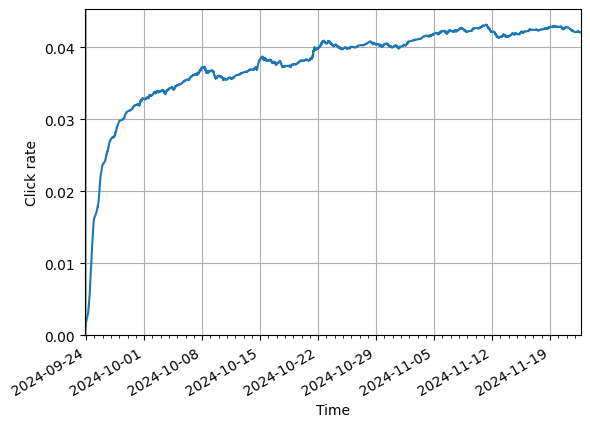

In [21]:
geometric_average(pulls, size=361812)
display_rates(pulls)

As suggested before, the click-through rates' plot for such a size is not helpful. 
Hence, we stick to a window size between $10^3$ and $10^5$.

## Conclusion and future improvements

- Instead of using the average number of pulls per week during September-November 2024 as a window size, we opt for a window size between $10^3$ and $10^5$, with a preference towards $10^5$ (resulting in more precise click-through rates).
- As autumn is the period of the year with more events, a similar analysis could be conduced on more weeks (computational cost allowing) or on a different period of the year, to have a more realistic number of pulls per week of Swapcard's platform. 
- In addition, for small/new users, information is scattered/little, so in these cases we may want to expand the size of the sliding window in order to extract more information. A way to do that could be to adjust the size of the sliding window using a multiplicative parameter (inversely proportional to the degree of activity of users).